## This notebook can be used to rank a list of nodes from a category that connect to an entity such as a gene. 
#### Example 1: Which disease are associate with NPM1 gene?
#### Example 2: Which proteins interacts with protein NPM1?
#### Example 3: Which drugs or small molecules can interact with NPM1?


In [1]:
import sys
sys.path.append('../src')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Step1: List all the APIs in the translator system
APInames = TCT.list_Translator_APIs()
APInames_current = TCT.get_Translator_APIs()
#set(APInames_current)-set(APInames)
APInames_current

['Monarch API',
 'Complex Portal Web Service',
 'Sri-name-resolver',
 'EBI Proteins API',
 'CTD API',
 'Workflow-runner(Trapi v1.4.0)',
 'LitVar API',
 'Automat-monarchinitiative(Trapi v1.4.0)',
 'Cqs(Trapi v1.5.0)',
 'Ontology Lookup Service API',
 'Workflow-runner(Trapi v1.5.0)',
 'Sri-answer-appraiser(Trapi v1.5.0)',
 'QuickGO API',
 'Automat-monarchinitiative(Trapi v1.5.0)',
 'Cqs(Trapi v1.4.0)',
 'Sri-answer-appraiser(Trapi v1.4.0)',
 'Automat-gtex(Trapi v1.4.0)',
 'Automat-cam-kp(Trapi v1.4.0)',
 'Sri-node-normalizer(Trapi v1.4.0)',
 'Automat-pharos(Trapi v1.4.0)',
 'mediKanren',
 'Autonomous Relay System (ARS) TRAPI',
 'Automat-drug-central(Trapi v1.4.0)',
 'Automat-intact(Trapi v1.4.0)',
 'Automat-ubergraph(Trapi v1.4.0)',
 'Automat-cam-kp(Trapi v1.5.0)',
 'Automat-human-goa(Trapi v1.5.0)',
 'Automat-hmdb(Trapi v1.4.0)',
 'mediKanren',
 'Automat-gtopdb(Trapi v1.4.0)',
 'Automat-ctd(Trapi v1.4.0)',
 'Connections Hypothesis Provider API',
 'Automat-icees-kg(Trapi v1.4.0)',
 'Auto

In [5]:
# Step 2: Get metaKG and all predicates from Translator APIs
metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs  # This need revision because of the metaKG information changes from the SmartAPI team
print(metaKG.columns)
print(metaKG.shape)

#metaKG.to_csv('../metaData/metaKG.csv', index=False)
#metaKG = pd.read_csv('../metaData/metaKG.csv')
All_predicates = list(set(metaKG['KG_category']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))
#All_categories

Index(['API', 'KG_category', 'Subject', 'Object', 'URL'], dtype='object')
(13624, 5)


In [6]:
# Step 3: set input parameters
# Test multiomics BigGIM Drug Response KP
# Node1 for query
input_node1 = 'NPM1'
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)
input_node1_list = [input_node1_id]
input_node1_category = ['biolink:Gene'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
input_node2_category = ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']
#input_node2_category = ['biolink:Gene']

# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,
                                              obj_list=input_node2_category,
                                              metaKG=metaKG)))



print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

NCBIGene:4869
all relevant predicates in Translator:
['biolink:related_to_at_instance_level', 'biolink:causes', 'biolink:increases_response_to', 'biolink:associated_with', 'biolink:part_of', 'biolink:has_output', 'biolink:occurs_together_in_literature_with', 'biolink:negatively_correlated_with', 'biolink:binds', 'biolink:genetically_associated_with', 'biolink:decreases_response_to', 'biolink:response_affected_by', 'biolink:is_substrate_of', 'biolink:derives_into', 'biolink:derives_from', 'biolink:has_part', 'biolink:produced_by', 'biolink:sensitivity_associated_with', 'biolink:resistance_associated_with', 'biolink:output_of', 'biolink:disrupts', 'biolink:disrupted_by', 'biolink:has_gene_product', 'biolink:coexists_with', 'biolink:directly_physically_interacts_with', 'biolink:has_substrate', 'biolink:affected_by', 'biolink:interacts_with', 'biolink:affects_response_to', 'biolink:related_to', 'biolink:associated_with_resistance_to', 'biolink:affects', 'biolink:physically_interacts_with',

In [7]:
# Step 4: Format query json
query_json = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates

# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs,query_json=query_json, max_workers=len(API_URLs))

# Step 6: Parse results
result_parsed = TCT.parse_KG(result)

# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:1017"


'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
Warning Code:404:https://api.bte.ncats.io/v1/8f08d1446e0bb9c2b323713ce83e2bd3/query
Warning Code:404:https://api.bte.ncats.io/v1/bde72db681ec0b8f9eeb67bb6b8dd72c/query
Warning Code:405:https://automat.ci.transltr.io/hetio/1.4/queryWarning Code:405:https://automat.ci.transltr.io/cam-kp/1.4/query?limit=100Warning Code:405:https://automat.ci.transltr.io/ctd/1.4/query


Warning Code:404:https://ars-prod.transltr.io/ara-robokop/api/runquery
Warning Code:405:https://automat.renci.org/icees-kg/1.4/queryWarning Code:405:https://automat.renci.org/gtopdb/1.4/query

Warning Code:405:https://automat.renci.org/pharos/1.4/query
Warning Code:4

In [8]:
print(query_json)

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['NCBIGene:4869'], 'categories': ['biolink:Gene']}, 'n1': {'categories': ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:related_to_at_instance_level', 'biolink:causes', 'biolink:increases_response_to', 'biolink:associated_with', 'biolink:part_of', 'biolink:has_output', 'biolink:occurs_together_in_literature_with', 'biolink:negatively_correlated_with', 'biolink:binds', 'biolink:genetically_associated_with', 'biolink:decreases_response_to', 'biolink:response_affected_by', 'biolink:is_substrate_of', 'biolink:derives_into', 'biolink:derives_from', 'biolink:has_part', 'biolink:produced_by', 'biolink:sensitivity_associated_with', 'biolink:resistance_associated_with', 'biolink:output_of', 'biolink:disrupts', 'biolink:disrupted_by', 'biolink:has_gene_product', 'biolink:coexists_with', 'biolink:directly_physically_interacts_with', 'biolink:has

CHEBI:64310no preferred name
CHEBI:78432no preferred name
CHEBI:34648no preferred name
MESH:D014874no preferred name
CHEBI:34892no preferred name
CHEBI:105942no preferred name
CHEBI:45783no preferred name
CHEBI:49791no preferred name
CHEBI:39112no preferred name
CHEBI:4775no preferred name
CHEBI:1224no preferred name
CHEBI:92401no preferred name
CHEBI:26536no preferred name
CHEBI:15367no preferred name
CHEBI:51024no preferred name
CHEBI:32687no preferred name
CHEBI:93427no preferred name
CHEBI:63996no preferred name
CHEBI:93069no preferred name
CHEBI:17447no preferred name
CHEBI:51687no preferred name
CHEBI:34575no preferred name
CHEBI:94192no preferred name
CHEBI:110200no preferred name
CHEBI:135921no preferred name
CHEBI:23053no preferred name
CHEBI:28088no preferred name
CHEBI:18220no preferred name
CHEBI:45716no preferred name
CHEBI:90942no preferred name
CHEBI:143117no preferred name
CHEBI:125472no preferred name
CHEBI:51210no preferred name
CHEBI:4357no preferred name
CHEBI:91662

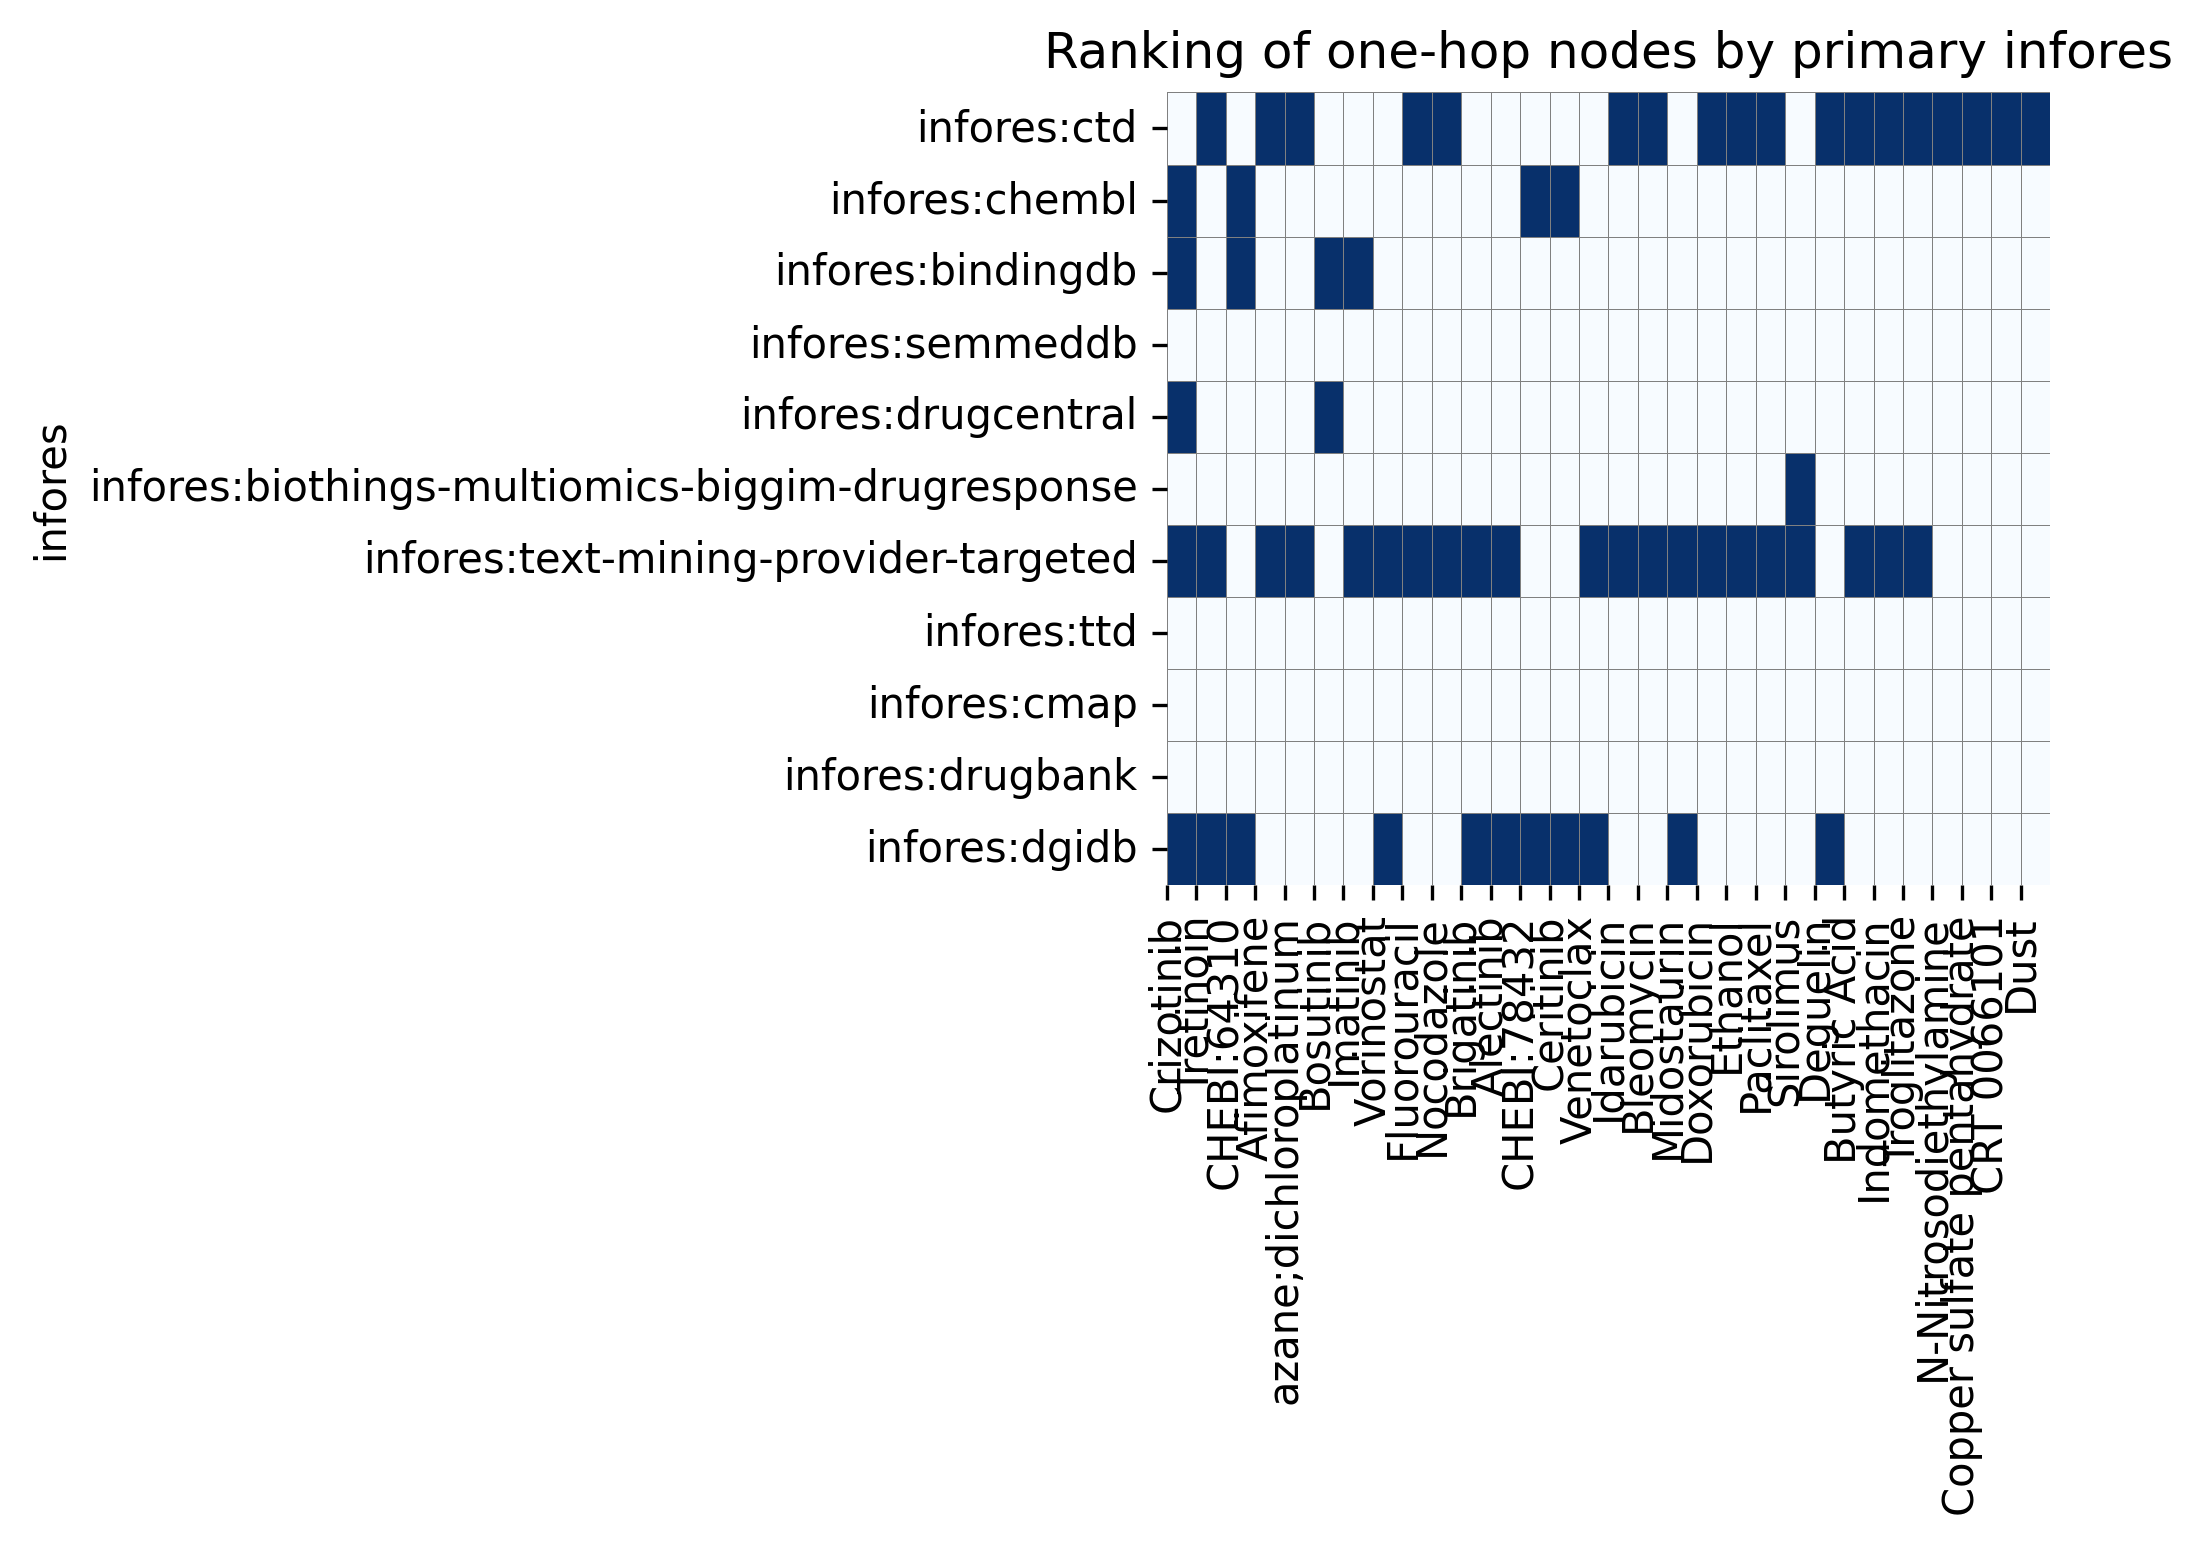

[Text(0.5, 0, 'Crizotinib'), Text(2.5, 0, 'CHEBI:64310'), Text(4.5, 0, 'azane;dichloroplatinum'), Text(6.5, 0, 'Imatinib'), Text(8.5, 0, 'Fluorouracil'), Text(10.5, 0, 'Brigatinib'), Text(12.5, 0, 'CHEBI:78432'), Text(14.5, 0, 'Venetoclax'), Text(16.5, 0, 'Bleomycin'), Text(18.5, 0, 'Doxorubicin'), Text(20.5, 0, 'Paclitaxel'), Text(22.5, 0, 'Deguelin'), Text(24.5, 0, 'Indomethacin'), Text(26.5, 0, 'N-Nitrosodiethylamine'), Text(28.5, 0, 'CRT 0066101')]


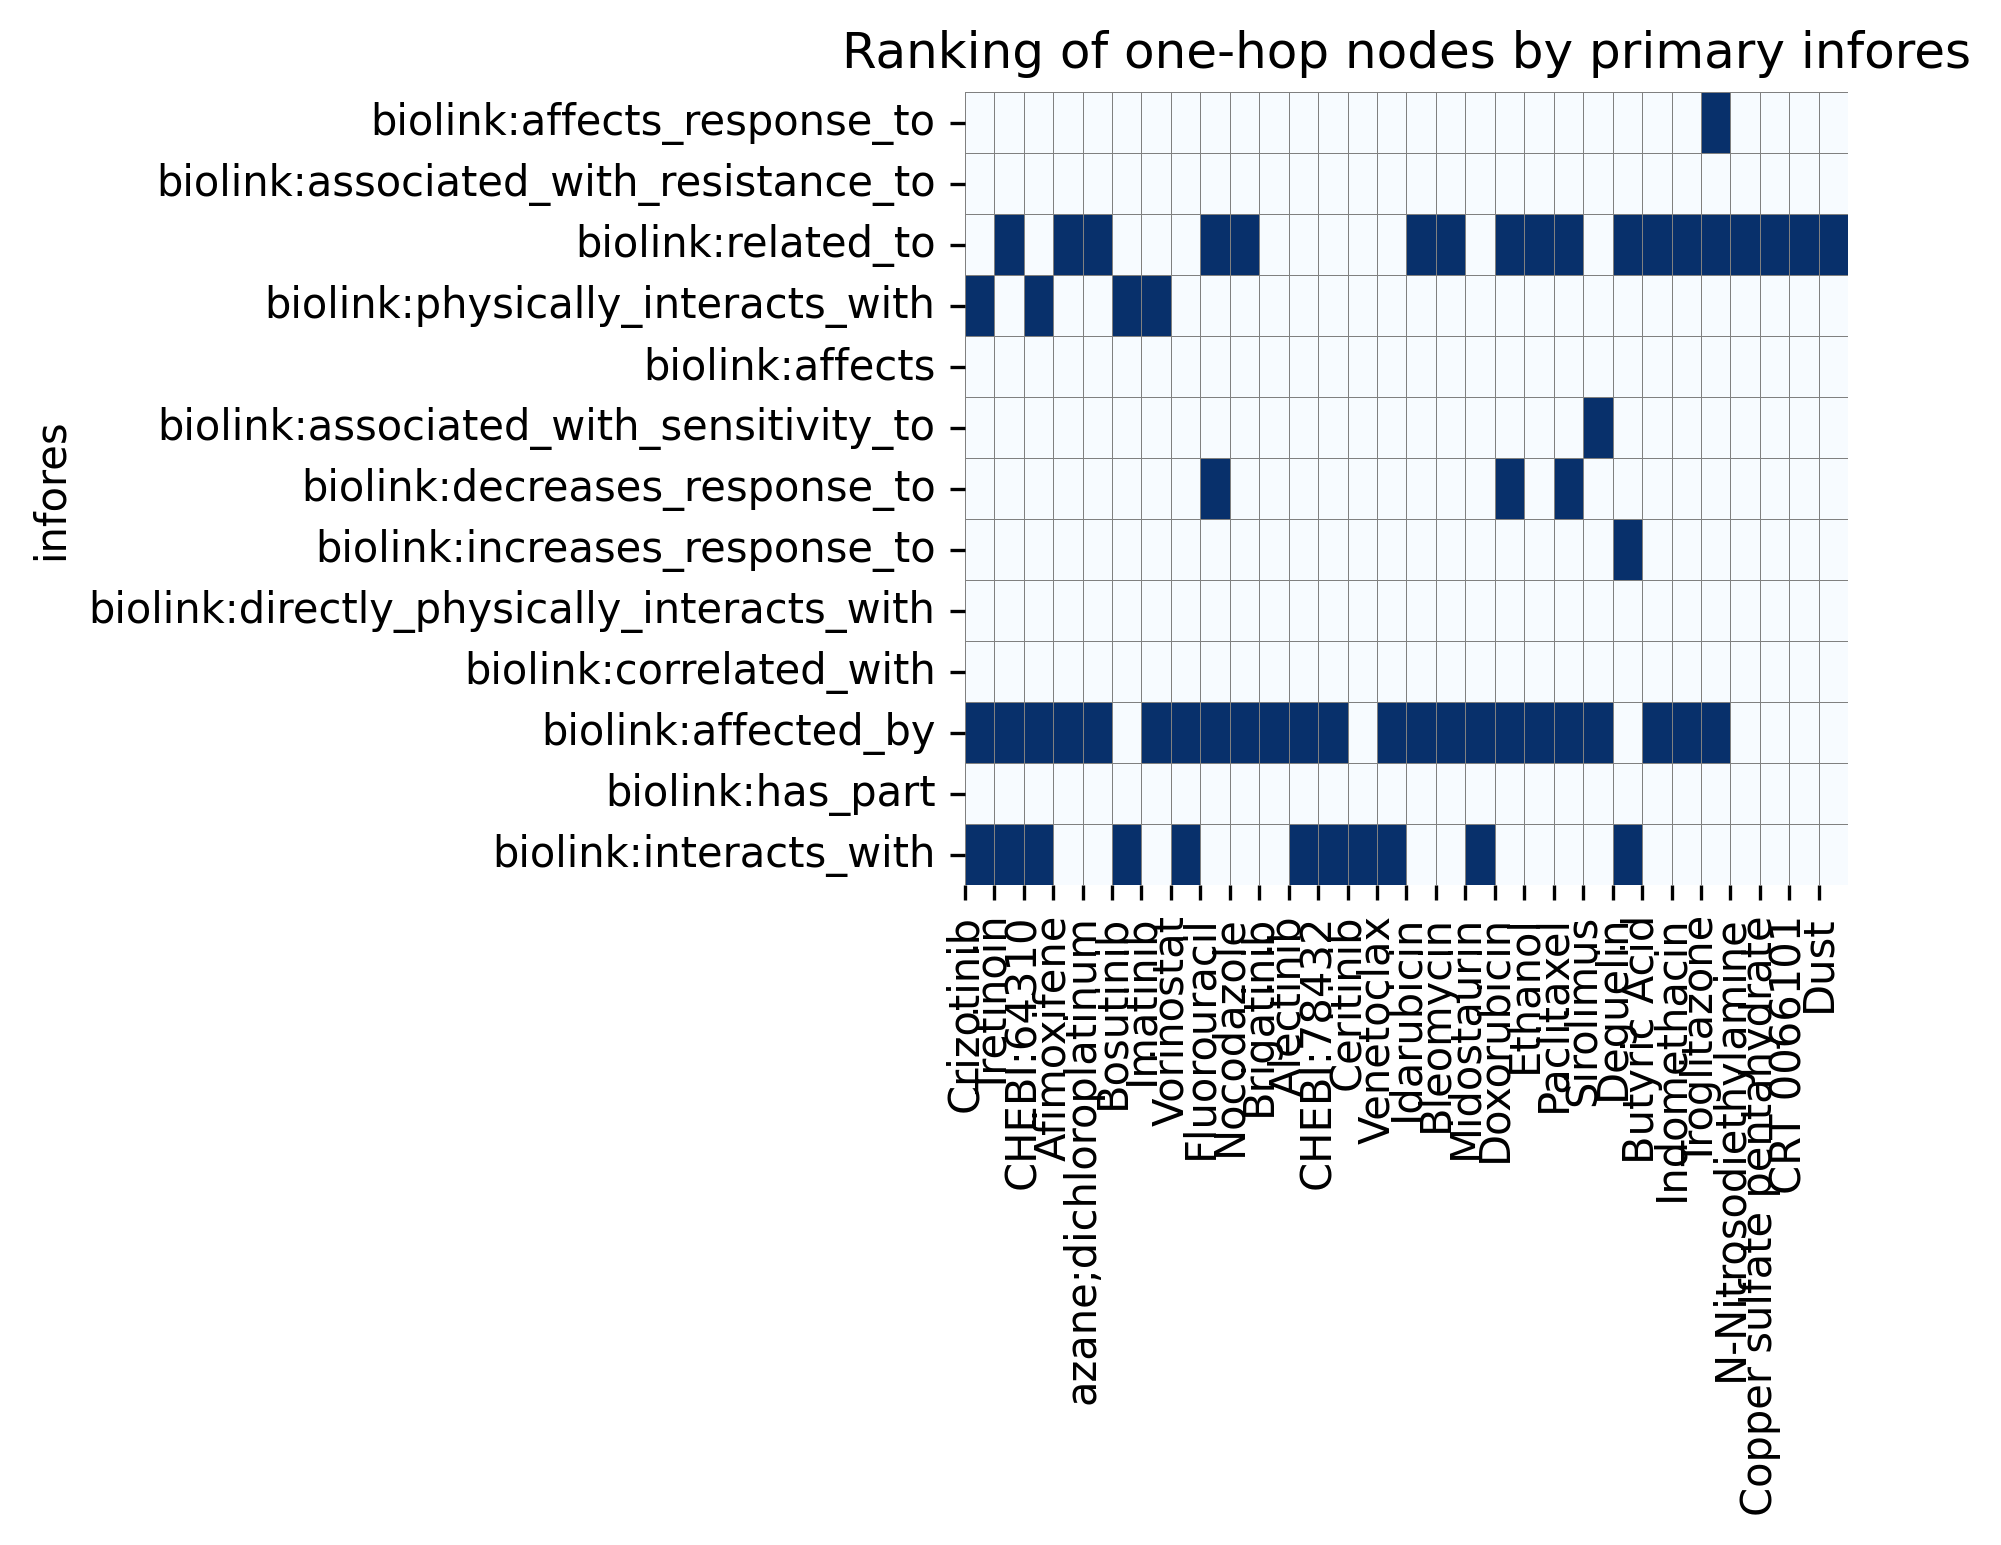

,Crizotinib,Tretinoin,CHEBI:64310,Afimoxifene,azane;dichloroplatinum,Bosutinib,Imatinib,Vorinostat,Fluorouracil,Nocodazole,...,Human interleukin-2,DOXYCYCLINE ANHYDROUS,"6-(2,6-dichlorophenyl)-8-methyl-2-((3-(methylthio)phenyl)amino)pyrido[2,3-d]pyrimidin-7(8H)-one",2-(4-methoxyphenyl)-1H-quinazolin-4-one,Ellagic Acid,TTD.DRUG:D0Z1OR,Lorlatinib,Ixazomib,"N2-[2-Methoxy-4-[4-(4-methyl-1-piperazinyl)-1-piperidinyl]phenyl]-N4-[2-[(1-methylethyl)sulfonyl]phenyl]-1,3,5-triazine-2,4-diamine",Zinc
biolink:affects_response_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:associated_with_resistance_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:related_to,0,1,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
biolink:physically_interacts_with,1,0,1,0,0,1,1,0,0,0,...,0,0,1,1,1,0,0,0,0,0
biolink:affects,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:associated_with_sensitivity_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:decreases_response_to,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
biolink:increases_response_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:directly_physically_interacts_with,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:correlated_with,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, 
                                num_of_nodes = 30, input_query = input_node1_id, 
                                fontsize = 10)


In [8]:
# End of the example